En este proyecto, debemos analizar datos mediante el proceso **CRISP-DM**. El proceso CRISP-DM se detalla a continuación.

#### CRISP-DM (Proceso Estándar Intersectorial para Minería de Datos)
- Comprensión del Negocio
- Comprensión de Datos
- Preparación de Datos
- Modelado
- Evaluación
- Implementación

En este núcleo, analizo datos siguiendo este proceso.

## Entendimiento del Negocio

Airbnb es una plataforma de alojamiento que satisface las necesidades de alojamiento y de préstamo.
Su principal fuente de ingresos es la **comisión del anfitrión**. Básicamente, a medida que aumenta el número de transacciones entre el anfitrión y el huésped, también aumentan sus ganancias.
Por lo tanto, es importante para su negocio y espero que sea uno de sus KPI.

<img src="https://bmtoolbox.net/wp-content/uploads/2016/06/airbnb.jpg" width=700>

ref: https://bmtoolbox.net/stories/airbnb/

#### ¿Qué podemos hacer para aumentar las transacciones?
Consideré las tres preguntas a continuación para explorar el camino.

* **¿Cuál es el período disponible para alquilar habitaciones?**
¿Hay habitaciones disponibles durante años? ¿O casi todas están disponibles en un solo día o una semana?

Aquí, quiero conocer la tendencia en el esquema de datos.

* **¿Hay temporada alta?**
Si la demanda de alojamiento supera la cantidad de habitaciones disponibles para alquilar, se pierden oportunidades de negocio.

Por lo tanto, quiero saber si hay temporada alta. De ser así, debemos crear un mecanismo para aumentar la cantidad de habitaciones disponibles para alquilar durante la temporada alta.

* **¿Se puede predecir el precio?**


## Comprensión de Datos

Tenemos tres datos:

* `Listados`: incluye descripciones completas y la puntuación media de las reseñas
* `Calendario`: incluye el ID del anuncio, el precio y la disponibilidad para ese día
* `Reseñas`: incluye el ID único de cada reseñador y comentarios detallados

En esta parte, realizaré visualizaciones y agregación para comprender las características de los datos.

In [1]:
# import necessary package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
seattle_calendar = pd.read_csv('../data/calendar.csv')
seattle_listing = pd.read_csv('../data/listings.csv')
seattle_review = pd.read_csv('../data/reviews.csv')

### calendario

Veamos las primeras 5 filas de datos y la información de la columna.

In [3]:
seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
seattle_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


Hay 4 columnas.
Aquí encontré algunas características de los datos.

* No solo se almacenan los días disponibles en los datos, sino que también parecen almacenarse los días no disponibles.
* Si los valores "disponibles" son "f", los valores "precio" parecen ser "NaN".
* Los valores "precio" se almacenan como objetos, no como enteros. Esto hace que el valor se almacene como "$xx.xx", y es necesario transformar esta columna.

En respuesta al resultado, tengo dos preguntas.

1. Si los valores disponibles son f, los valores de precio parecen ser NaN. Pero esto es solo una hipótesis, ¿es cierto para todos los datos?
2. ¿Cuántas filas hay por cada listing_id?

Respondamos estas preguntas explorando los datos.

In [5]:
#  If the available values are f, the price values seems to be NaN. But it is only a hypothesis, is it true all data?
calendar_q1_df = seattle_calendar.groupby('available')['price'].count().reset_index()
calendar_q1_df.columns = ['available', 'price_nonnull_count']
calendar_q1_df

,available,price_nonnull_count
0,f,0
1,t,934542


In [6]:
#  How many rows per each listing_id?
calendar_q2_df = seattle_calendar.groupby('listing_id')['date'].count().reset_index()
calendar_q2_df['date'].value_counts()

date
365    3818
Name: count, dtype: int64

Arriba, puedo responder a mi pregunta. La respuesta es:

***Si los valores disponibles son f, los valores de precio parecen ser NaN. Pero es solo una hipótesis, ¿son ciertos todos los datos?***
-> ¡Verdadero!

***¿Cuántas filas por cada listing_id?***
-> Registro de 365 días. Esto equivale a un año.

Ahora casi entiendo las características de los datos.
Finalmente, investigaré si hay alguna tendencia en el precio de las propiedades.

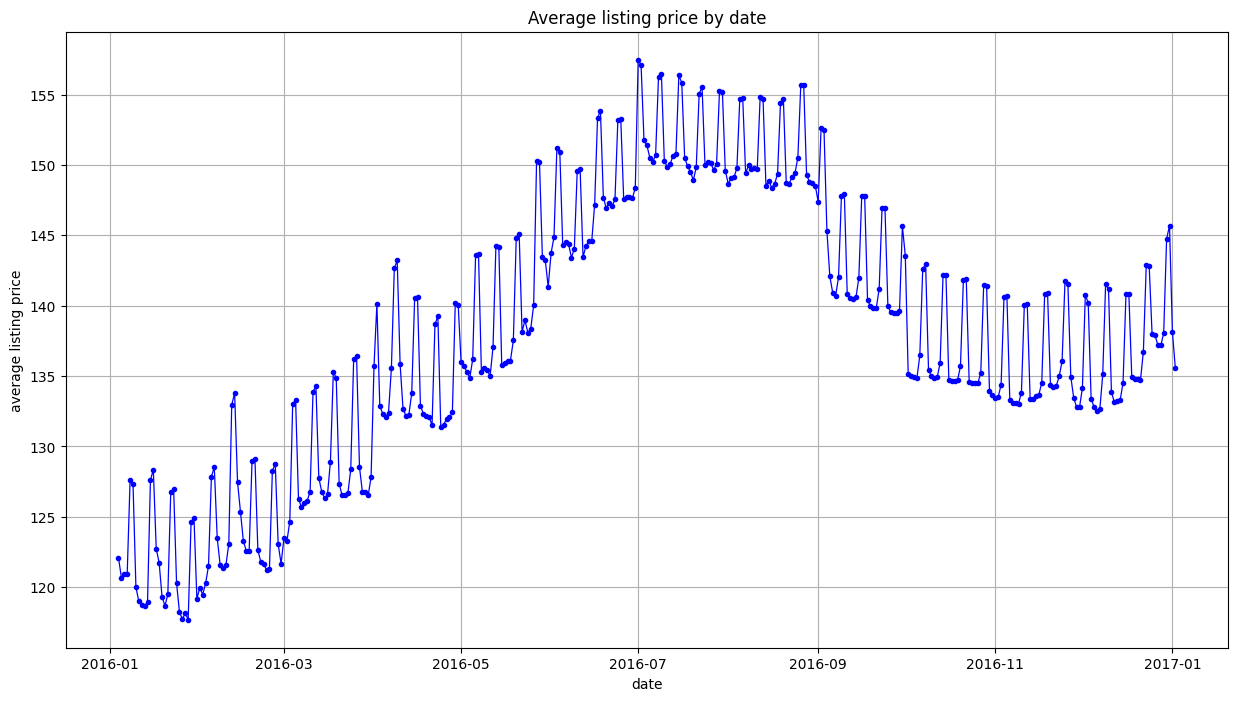

In [7]:
# process data
calendar_q3_df = seattle_calendar.copy(deep=True)
calendar_q3_df.dropna(inplace=True)
calendar_q3_df['date'] = pd.to_datetime(calendar_q3_df['date'])
calendar_q3_df['price'] = calendar_q3_df['price'].map(lambda x: float(x[1:].replace(",", "")))

# apply aggregation
calendar_q3_df = calendar_q3_df.groupby('date')['price'].mean().reset_index()

# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(calendar_q3_df.date, calendar_q3_df.price, color='b', marker='.', linewidth=0.9)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.grid()

Esto es interesante.
Hay dos tendencias en los datos:

1. El precio promedio aumenta de 2016/1 a 2016/7, alcanza un máximo durante tres meses y luego disminuye. El precio promedio de 2017/1 es mayor que el de hace un año.
2. Hay pequeños picos periódicos.

La primera tendencia se puede dividir en dos factores: uno es estacional y el otro, general.
La segunda tendencia parece semanal, así que veámosla con atención.

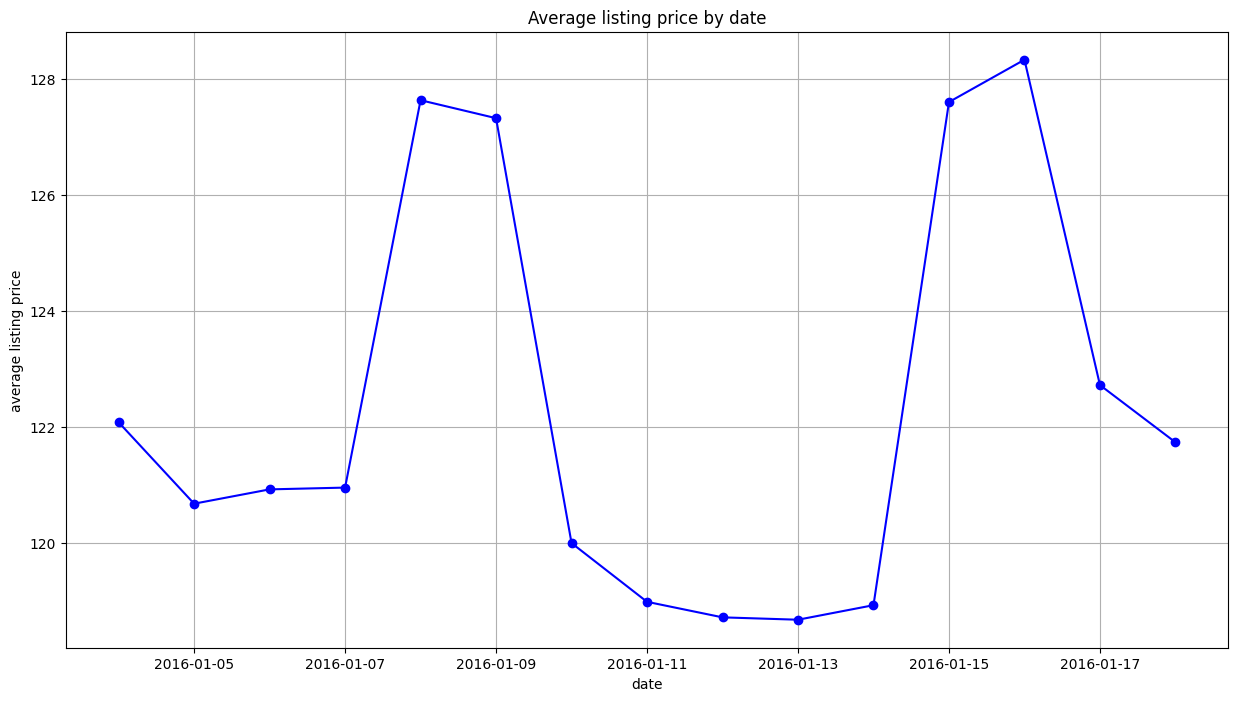

In [8]:
# plot more narrow range
plt.figure(figsize=(15, 8))
plt.plot(calendar_q3_df.date.values[:15], calendar_q3_df.price.values[:15], color='b', marker='o', linewidth=1.5)
plt.title("Average listing price by date")
plt.xlabel('date')
plt.ylabel('average listing price')
plt.grid()

Parece una tendencia semanal, como pensaba. Entonces, ¿qué día de la semana tiene el precio más alto?

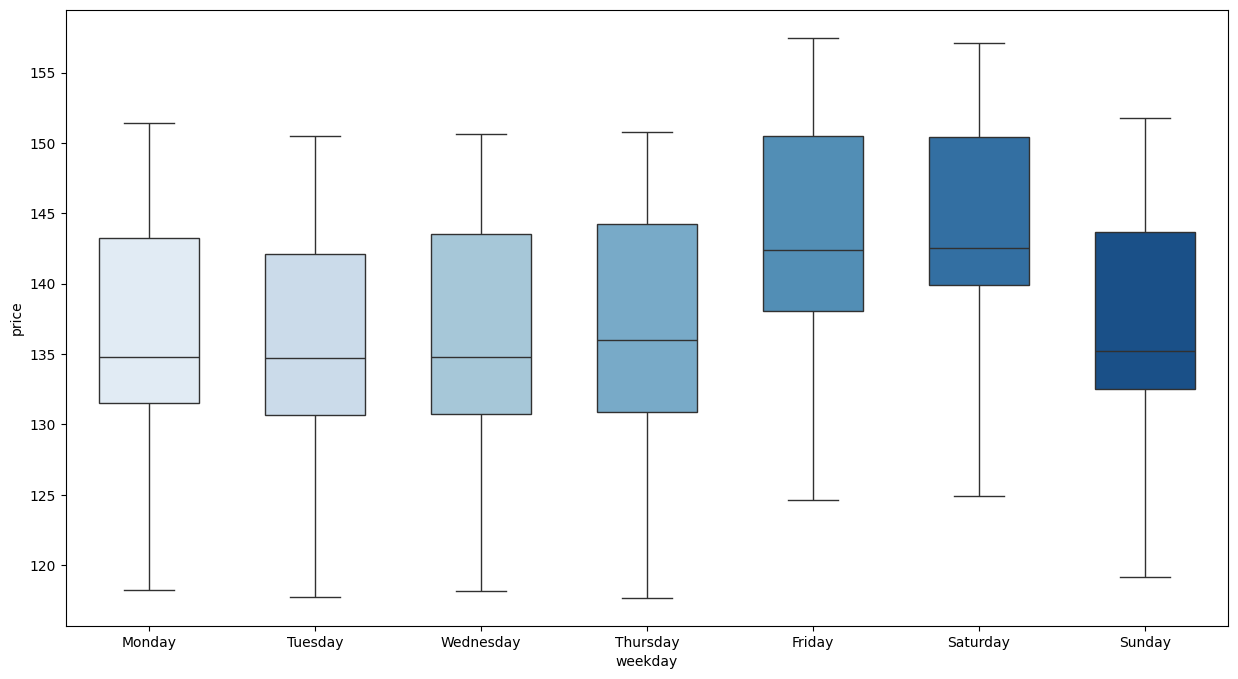

In [9]:

calendar_q3_df["weekday"] = calendar_q3_df["date"].dt.day_name()

plt.figure(figsize=(15, 8))
sns.boxplot(x='weekday', y='price', data=calendar_q3_df, palette="Blues", width=0.6)
plt.show()

El fin de semana, viernes y sábado tienen precios altos.

#### Resumen

* Cada anuncio tiene un registro de 365 días en estos datos.
* Si los valores de disponibilidad son f, los valores de precio son NaN.
* Existe una tendencia semanal: los precios de los anuncios en fin de semana son más altos que en otros días laborables.

### listados

Comencemos mirando las primeras 5 filas de datos y las columnas de información.

In [10]:
seattle_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [11]:
print(list(seattle_listing.columns.values))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'gues

Hay muchas columnas, así que no puedo explorarlas todas aquí. Aquí analizaré algunas columnas que me interesan.

Primero, investigaré cuántos listados hay en los datos.

In [12]:
print("Num of listings: ", seattle_listing.id.count())
print("Num of rows: ", seattle_listing.shape[0])

Num of listings:  3818
Num of rows:  3818


Esto muestra que cada fila representa listados únicos.

A continuación, me interesan las siguientes columnas:

* calificación_reseñas
* precio
* noches_máximas

¿Cuál es la distribución de estos valores en cada columna? ¿Es asimétrica o normal?

¡Veámoslo!

#### review_scores_rating

In [13]:
seattle_listing['review_scores_rating'].describe().reset_index()

,index,review_scores_rating
0,count,3171.000000
1,mean,94.539262
2,std,6.606083
3,min,20.000000
4,25%,93.000000
5,50%,96.000000
6,75%,99.000000
7,max,100.000000


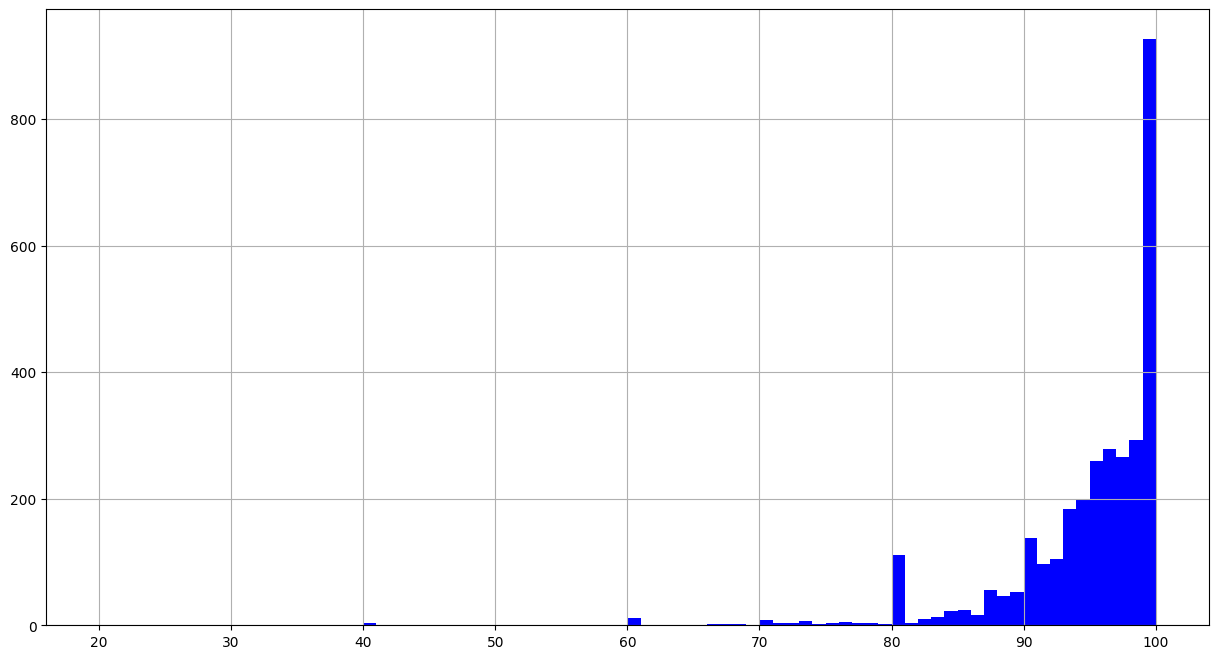

In [14]:
# cleaning data
listings_q1_df = seattle_listing['review_scores_rating'].dropna()

# plot histgram
plt.figure(figsize=(15, 8))
plt.hist(listings_q1_df.values, bins=80, color='b')
plt.grid()

Esta es una distribución muy sesgada a la derecha.
Los valores del 75 % o más son 90 puntos. Y el valor más común es 100 puntos.
Puedo decir que los listados con puntuaciones bajas son minoritarios.

#### price

In [15]:
# cleaning data
listings_q2_df = seattle_listing.copy(deep=True)
listings_q2_df = listings_q2_df['price'].dropna().reset_index()
listings_q2_df['price'] = listings_q2_df['price'].map(lambda x: float(x[1:].replace(',', '')))

listings_q2_df['price'].describe().reset_index()

,index,price
0,count,3818.000000
1,mean,127.976166
2,std,90.250022
3,min,20.000000
4,25%,75.000000
5,50%,100.000000
6,75%,150.000000
7,max,1000.000000


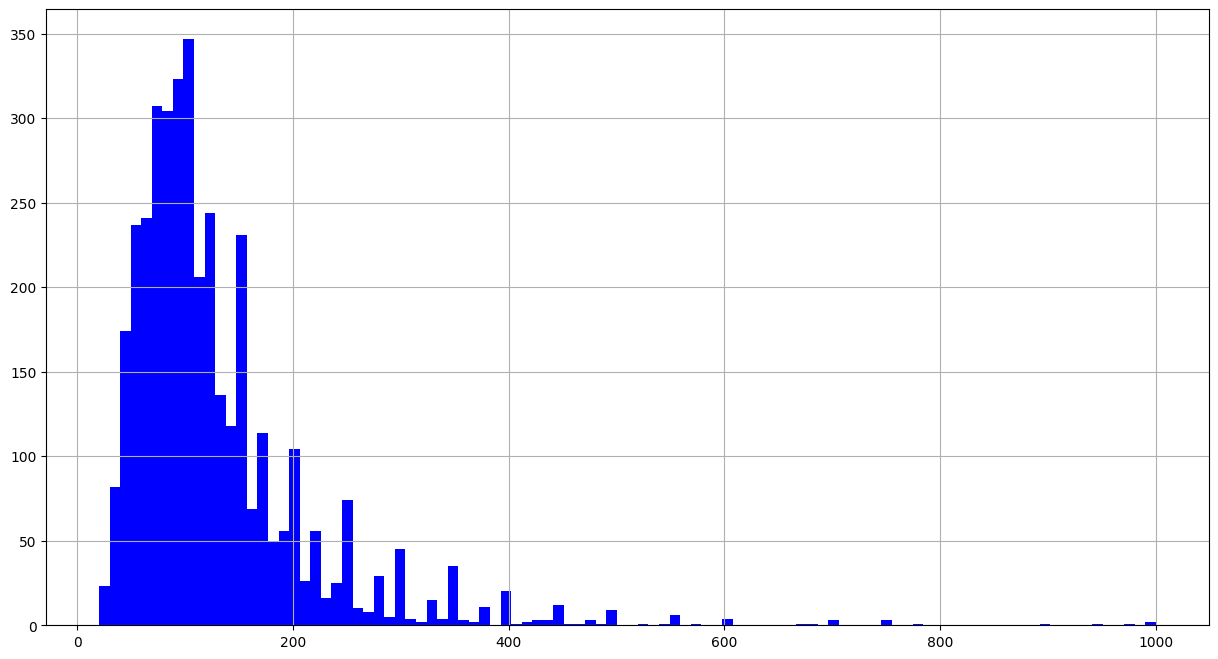

In [16]:
plt.figure(figsize=(15, 8))
plt.hist(listings_q2_df.price, bins=100, color='b')
plt.grid()

Esta es una distribución de cola larga. Los valores promedio oscilan entre 0 y 200.

#### maximum_nights

In [17]:
seattle_listing['maximum_nights'].describe().reset_index()

,index,maximum_nights
0,count,3818.000000
1,mean,780.447617
2,std,1683.589007
3,min,1.000000
4,25%,60.000000
5,50%,1125.000000
6,75%,1125.000000
7,max,100000.000000


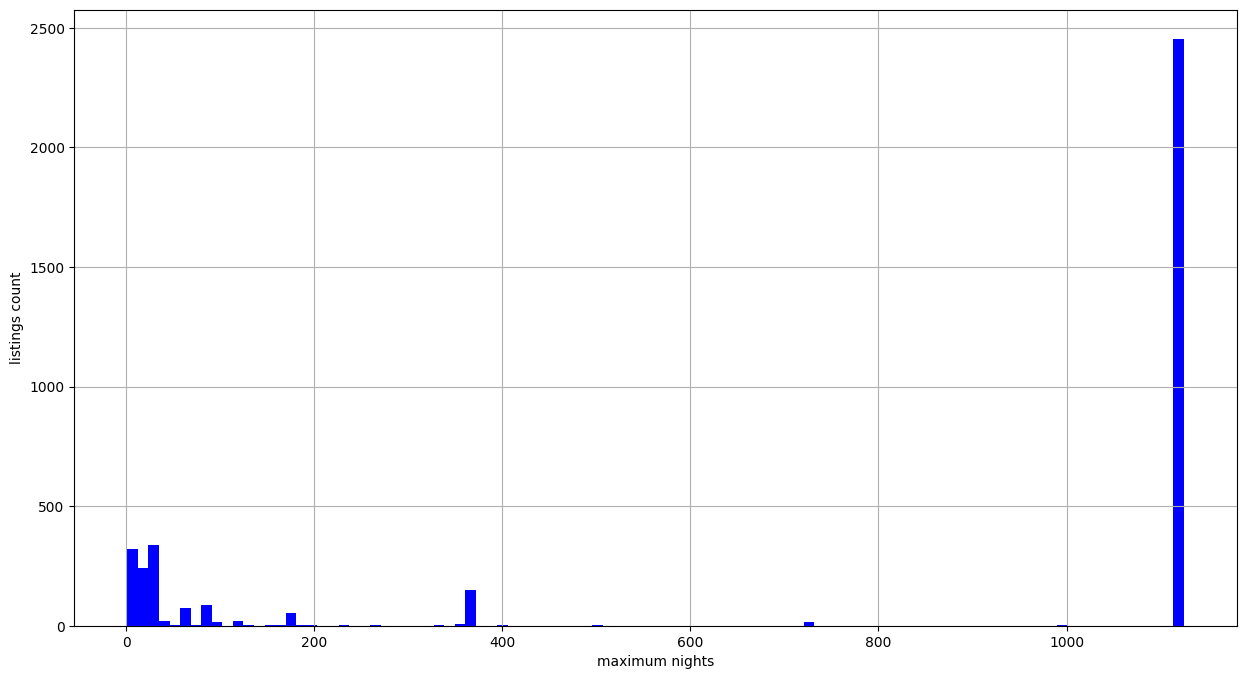

In [18]:
# eliminate outliers because maximum values are very large.
listings_q3_df = seattle_listing[seattle_listing['maximum_nights'] <= 1500]

plt.figure(figsize=(15, 8))
plt.hist(listings_q3_df.maximum_nights, bins=100, color='b')
plt.xlabel('maximum nights')
plt.ylabel('listings count')
plt.grid()

Esto es muy sorprendente, ya que esperaba que fuera como máximo una semana.
De hecho, casi todos los valores de `maxmum_night` están configurados en 1125.
No he usado Airbnb, así que no lo sé, pero quizás exista algo parecido al valor predeterminado.
O quizás haya dos segmentos: uno para `anuncios disponibles` y el otro para `anuncios a largo plazo como alquileres normales`.

#### Resumen

* Los datos de los anuncios tienen 92 columnas.
* La calificación de puntuaciones de reseñas tiene una distribución sesgada a la derecha, y la mayoría de los valores superan los 90 puntos.
* El precio tiene una distribución de cola larga, y la mayoría de los valores rondan los 100 $, pero algunos son mucho más altos que otros.
* El máximo de noches tiene una distribución muy particular. Hay dos segmentos: uno de aproximadamente 3 años y el otro de aproximadamente 1 semana.

Bien, veamos los últimos datos.

### reviews

Comencemos mirando las primeras 5 filas de datos y las columnas de información.

In [19]:
seattle_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [20]:
seattle_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


Hay seis columnas, como el ID del listado que recibió la reseña, el ID de las reseñas, la fecha de envío, etc.
Me preocupa que no haya puntuaciones de reseñas aquí. Creo que podría estar en los comentarios, así que confirmémoslo.

In [21]:
print("sample 1: ", seattle_review.comments.values[0], "\n")
print("sample 2: ", seattle_review.comments.values[3])

sample 1:  Cute and cozy place. Perfect location to everything!  

sample 2:  Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the Metropolitan (probably the coolest grocer you'll ever find). Easy to find and Kelly was warm, welcoming, and really interesting to talk to. 


De lo anterior se desprende que la puntuación de la revisión no parece estar incluida.

A continuación, quiero ver el cambio en la serie temporal del número de comentarios.

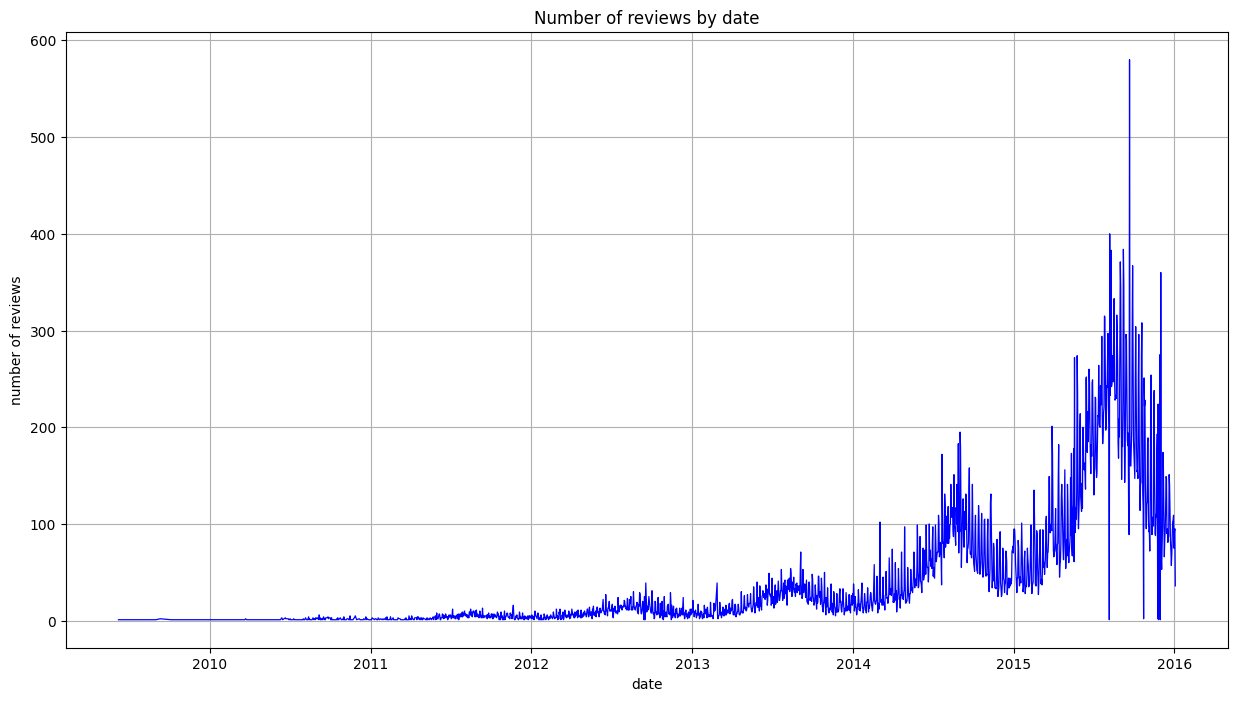

In [22]:
# convert date column's data type to date from object
review_q1_df = seattle_review.copy(deep=True)
review_q1_df.date = pd.to_datetime(review_q1_df.date)

review_q1_df = review_q1_df.groupby('date')['id'].count().reset_index()

# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(review_q1_df.date, review_q1_df.id, color='b', linewidth=0.9)
plt.title("Number of reviews by date")
plt.xlabel('date')
plt.ylabel('number of reviews')
plt.grid()

Hay un poco de ruido, pero podemos observar un aumento en el número de usuarios de Airbnb (y el rango de fechas es más amplio que el de los datos del calendario).
Y me doy cuenta de que parece tener un pico aproximadamente en la misma época cada año.
Por lo tanto, usemos medias móviles para suavizar el gráfico.

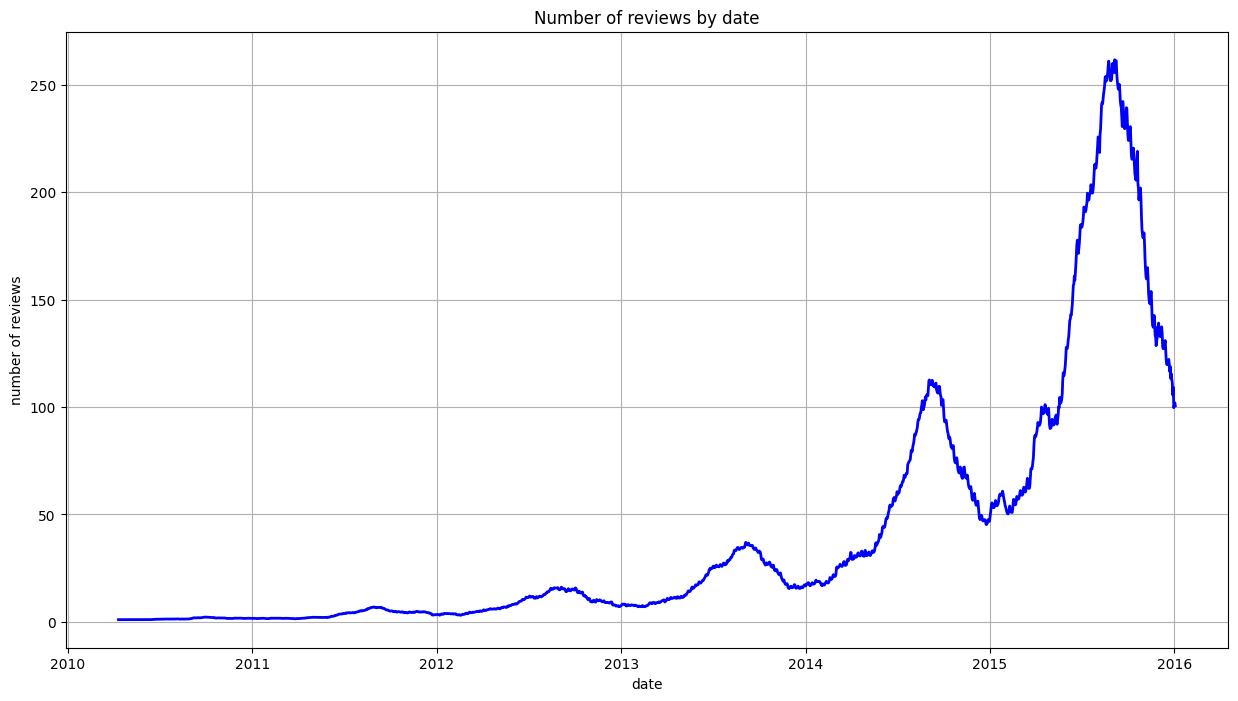

In [23]:
# create rolling mean column
review_q1_df["rolling_mean_30"] = review_q1_df.id.rolling(window=30).mean()

# plot avg listings prices over time.
plt.figure(figsize=(15, 8))
plt.plot(review_q1_df.date, review_q1_df.rolling_mean_30, color='b', linewidth=2.0)
plt.title("Number of reviews by date")
plt.xlabel('date')
plt.ylabel('number of reviews')
plt.grid()

Probé con un periodo de treinta días (aproximadamente un mes). El gráfico se suavizó y la tendencia se aclaró, y mi convicción de que los picos estaban en el mismo punto se fortaleció.
A continuación, extraigo el momento en que se produce el pico cada año.

In [24]:
review_q1_df["year"] = review_q1_df.date.dt.year
years = review_q1_df.year.unique()

for year in years:
    if year >= 2010 and year < 2016:
        year_df = review_q1_df[review_q1_df.year == year]
        max_value = year_df.rolling_mean_30.max()
        max_date = year_df[year_df.rolling_mean_30 == max_value].date.dt.date.values[0]
        print(year, max_date, np.round(max_value, 1))

2010 2010-10-04 2.3
2011 2011-08-31 7.0
2012 2012-09-04 16.2
2013 2013-09-04 37.0
2014 2014-09-03 112.6
2015 2015-09-05 261.6


Mi hipótesis es correcta.
¡El pico parece ser a principios de septiembre!
¿Son vacaciones de verano?

### Responde mi pregunta

Hasta ahora, puedo responder a dos de las tres preguntas mencionadas al principio.

Primero, respondamos a la pregunta:
**¿Cuál es el periodo disponible para alquilar habitaciones?**

Esto se observó al analizar los datos de los anuncios. Había dos grupos: anuncios disponibles en lugares con un máximo de noches inferior a una semana y anuncios con un periodo de alquiler de hasta tres años.

Para una explicación más detallada, dibuje un diagrama de dispersión con el máximo y el mínimo de noches.

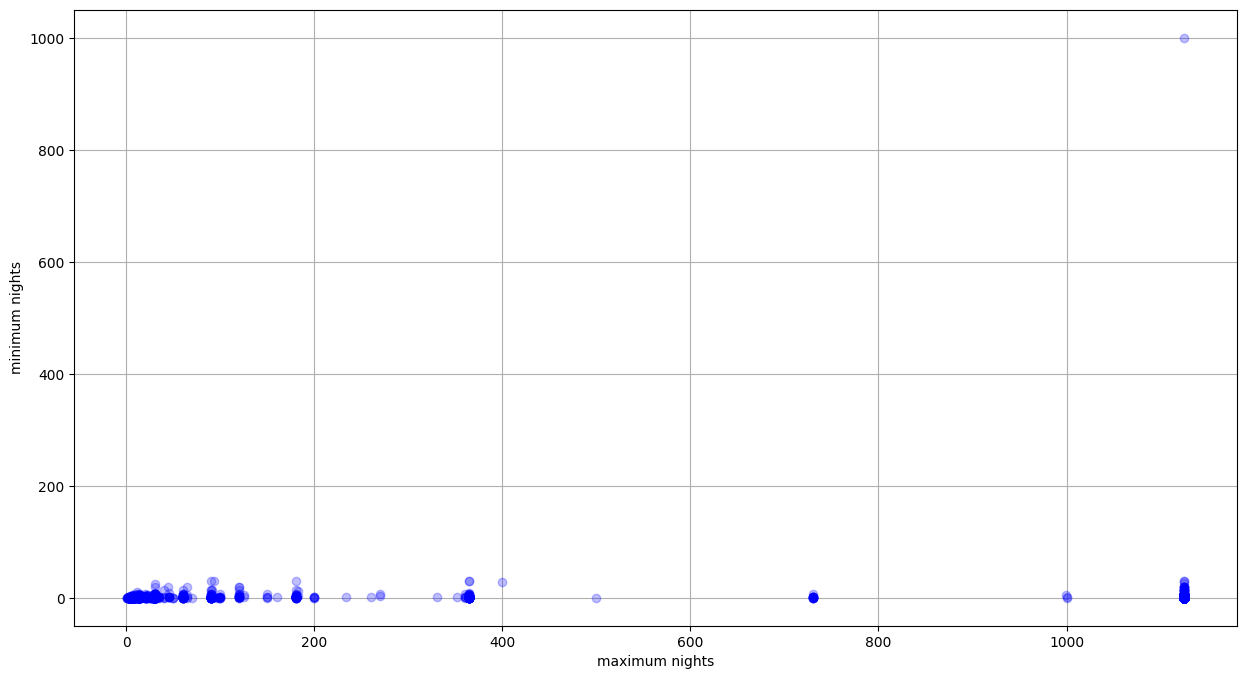

In [25]:
listings_q3_df["min_max_night_diff"] = listings_q3_df.maximum_nights - listings_q3_df.minimum_nights

plt.figure(figsize=(15, 8))
plt.plot(listings_q3_df.maximum_nights, listings_q3_df.minimum_nights, color='b', marker='o', linewidth=0, alpha=0.25)
plt.xlabel('maximum nights')
plt.ylabel('minimum nights')
plt.grid()

Desde aquí, se puede observar que el mínimo de noches se mantiene prácticamente constante, independientemente del máximo.
En otras palabras, se observa que los alojamientos con un máximo de noches elevado no se alquilan exclusivamente, sino que se gestionan ampliamente, desde el uso puntual hasta las estancias de larga duración.

Respondamos a la segunda pregunta.
**¿Hay temporada alta?**

No se puede determinar con exactitud, ya que la duración real de la estancia del usuario no se incluye en los datos, pero el número de reseñas se considera una guía.
Además, dado que anualmente se producen picos periódicos en el número de reseñas, se podría considerar que el barrio se encuentra en temporada alta.

Descubrimos que la temporada alta más importante fue a principios de septiembre, pero ¿cuánto durará? ¡Veámoslo con más detalle!

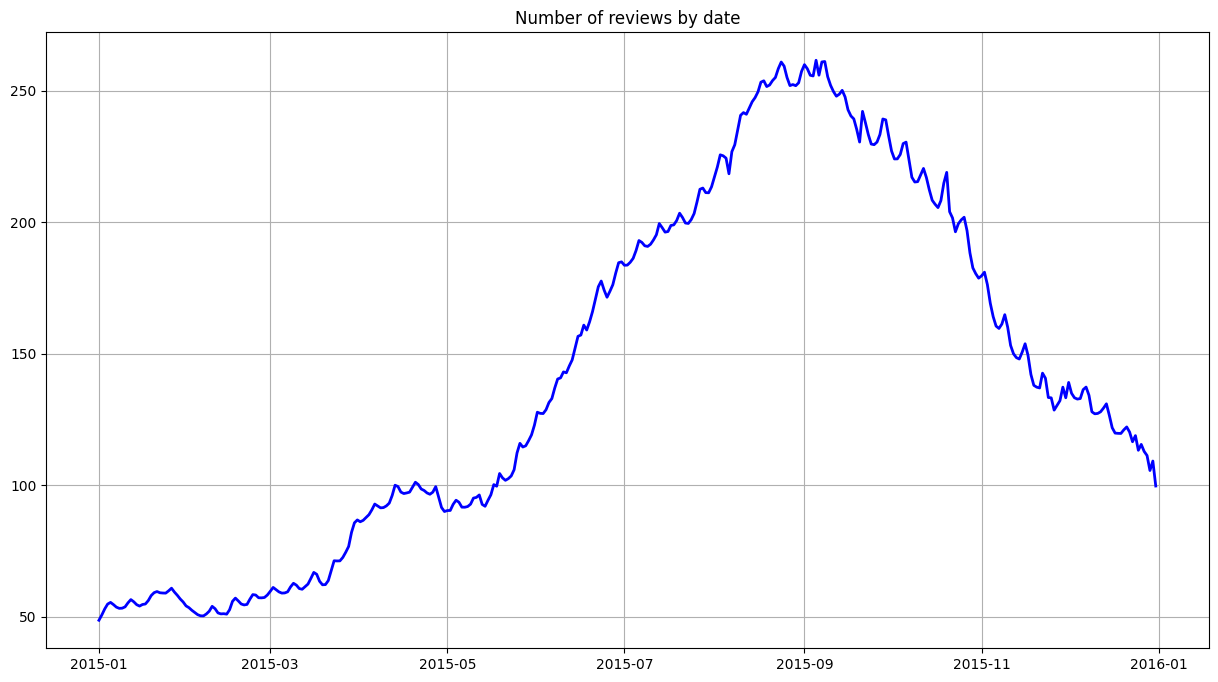

In [26]:
review_q2_df = review_q1_df[review_q1_df.year == 2015]

plt.figure(figsize=(15, 8))
plt.plot(review_q2_df.date, review_q2_df.rolling_mean_30, color='b', linewidth=2.0)
plt.title("Number of reviews by date")
plt.grid()

Es difícil determinar con claridad cuándo empezar y cuándo terminar.
Pero, desde aquí, se podría decir que la temporada alta es un mes antes y un mes después de septiembre.

 ## Resumen

Este cuaderno utiliza datos de Airbnb del área de Seattle y se ha analizado para responder a las siguientes preguntas.

Aquí resumimos las respuestas.

* **¿Cuál es el periodo disponible para alquilar habitaciones?**
El histograma del máximo de noches muestra dos grupos.

Uno es un anuncio que se puede usar en momentos específicos, como el máximo de noches por semana.

El otro es un anuncio que admite una amplia gama de estancias, desde estancias muy largas con un máximo de tres años o más y un mínimo de noches de aproximadamente dos días, hasta el uso puntual.

* **¿Hay temporada alta?**
La respuesta es **Sí**.

Además del aumento en el número de usuarios de Airbnb, sin duda hubo un aumento oportuno en el número de reseñas en la misma época cada año.

Se cree que es aproximadamente un mes a principios de septiembre y coincide con las vacaciones de verano. Es importante que la cantidad de propiedades disponibles en esta época supere la demanda.

